# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

In [1]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [2]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.system_dim = 2

    def polar_to_cartesian(self, r, theta):
        x = r * torch.cos(theta)
        y = r * torch.sin(theta)
     
        return torch.stack([x, y])
    
    def cartesian_to_polar(self, x, y):
        r = torch.sqrt(x**2 + y**2)
        theta = torch.atan2(y, x)
        return torch.stack([r, theta])


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)


In [ ]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [4]:
y0 = torch.tensor([[1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
y0.shape

torch.Size([3, 2])

In [29]:
lc.f(t = 0, x = y0).shape

torch.Size([3, 2])

In [ ]:
sol = odeint(func=lc.f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [ ]:

sol.shape

ValueError: only one element tensors can be converted to Python scalars

In [33]:
a = torch.arange(0.0, 2.0, 0.05); b = torch.arange(-2, 2, 0.5)
ic = torch.cartesian_prod(a, b).T


t_span = (0, 10); dt = 0.05
sol = lc.solve(x0=ic, t_span=t_span, dt=dt)


In [34]:
sol.shape

torch.Size([200, 2, 320])

In [15]:
sol = odeint(func=lc.f, y0=ic, t=torch.arange(0, 10, 0.1), method='rk4', options={'step_size': dt})

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
sol

In [ ]:
odeint(lc.f, ic, batch_time_i[i, :], method='rk4', options={'step_size': dt})

torch.Size([100, 2, 320])

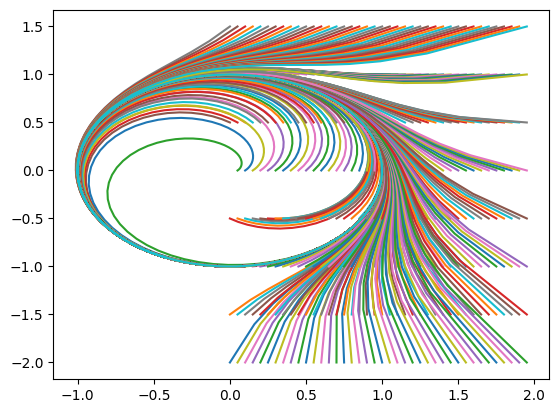

In [11]:
for i in range(ic.shape[1]):
    plt.plot(sol[:, 0, i], sol[:, 1, i], )

In [ ]:
# Augmenting with latent variable.

In [14]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [15]:
# Neural ODE - 

In [16]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [17]:
class Dynamic_Bif_NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE with time-varying latent variable. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
            self.r                  = None 
    
    def set_parameter(self, r):
        """Set the latent variable function that takes time and returns a float"""
        if not callable(r):
            raise TypeError(f"Expected a callable function, got {type(r)}")
        self.r = r

    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        r_tensor = torch.full((x.shape[0], 1), fill_value=self.r(t))
        input = torch.cat((x, r_tensor), dim=1)
        out = self.network(input) #(num_traj, spatial_dim+drivers)
        return out

In [18]:
model = Dynamic_Bif_NODE(input_dim=4, output_dim=3, depth=2, width=10, activation_func=nn.Tanh())  
model.set_parameter(r = lambda t: 1)

In [19]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [21]:
training_data_tensor.shape

torch.Size([1, 100, 2, 320])

In [189]:
t_eval_tensor.T.shape

torch.Size([200, 1])

In [191]:
pred_x_temp = odeint(model, training_data_tensor[0, 0, :, :].T, t_eval_tensor.T[:, 0], method='rk4', options={'step_size': dt})

RuntimeError: mat1 and mat2 shapes cannot be multiplied (320x3 and 4x10)

In [152]:
num_epochs = 2

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x321 and 4x10)

batch_length = 20
num_batch = 15
num_epochs = 1

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     

In [230]:
# Analysis of Trained Model

Text(0.5, 0, 'Epochs')

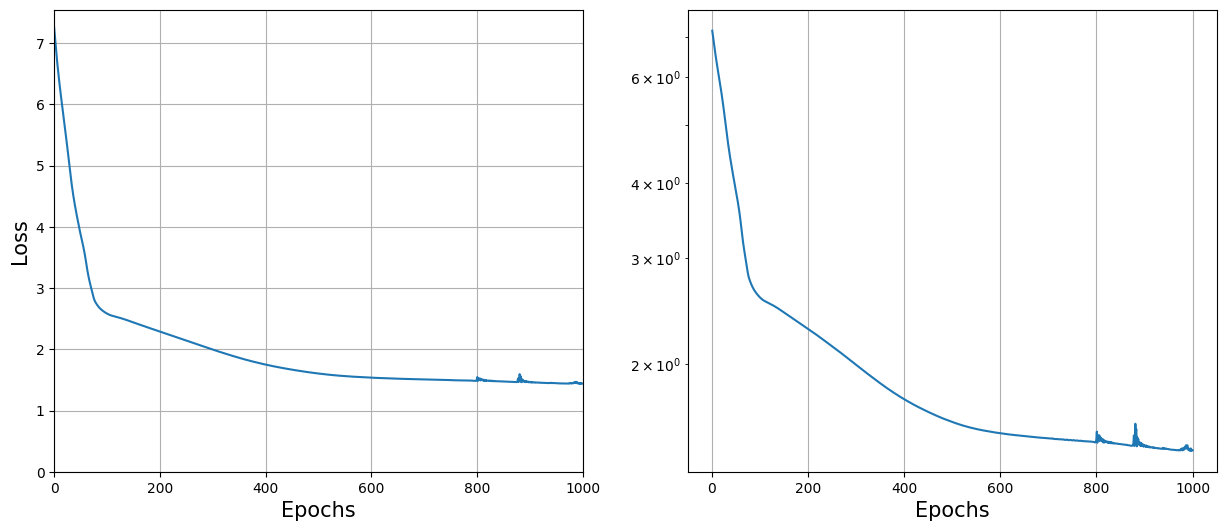

In [231]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [232]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

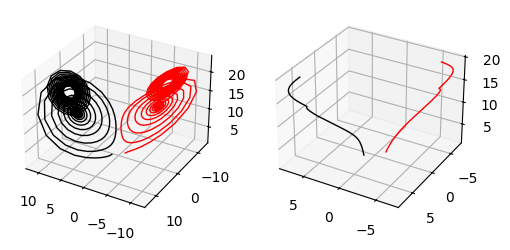

In [233]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()